In [1]:
from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [2]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from vecbool_data_gen import *

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clrkwng/vecbool/17fb3b3b97ad4baa875dcdc19c6bd4a6



In [4]:
%load_ext autoreload
%autoreload 2

## Code Testing

In [16]:
cache

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clrkwng/vecbool/fbff7734e4a74b51892c97872c4d8c74
COMET INFO:   Parameters:
COMET INFO:     balanceGTLabelFlag       : True
COMET INFO:     batch_flag               : True
COMET INFO:     batch_size               : 256
COMET INFO:     boolvec_dim              : 2
COMET INFO:     cont_range               : [0, 5]
COMET INFO:     emb_dims                 : [4, 8]
COMET INFO:     hidden_drop_p            : 0.1
COMET INFO:     lin_layer_sizes          : [128, 512, 1024, 800, 512, 128, 32, 20]
COMET INFO:     lr                       : 0.001
COMET INFO:     neighbor_bools           : [[1, 0]]
COMET INFO:     num_classes              : 10
COMET INFO:     num_cont                 : 2
COMET INFO:     num_epochs               : 100
COMET INFO:     rep_bools

{'X_train_mean': array([2.52367851, 2.47358698]),
 'X_train_std': array([1.67517175, 1.63338128])}

In [7]:
X_train, y_train = get_test_splitB(100000, 1)
np.unique(X_train[:, 2:], return_counts=True, axis=0)

(array([[0., 3.]]), array([18970]))

In [5]:
cache

{'X_train_mean': array([2.50133915, 2.49785036]),
 'X_train_std': array([1.63836071, 1.63638569])}

In [21]:
cache

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clrkwng/vecbool/026c4fff0d974e2da0361b630caceaa8
COMET INFO:   Parameters:
COMET INFO:     batch_flag      : True
COMET INFO:     batch_size      : 256
COMET INFO:     boolvec_dim     : 5
COMET INFO:     cont_range      : [0, 5]
COMET INFO:     emb_dims        : [10, 20]
COMET INFO:     hidden_drop_p   : 0.1
COMET INFO:     lin_layer_sizes : [680, 2048, 800, 512, 128, 32, 20]
COMET INFO:     lr              : 0.001
COMET INFO:     num_classes     : 10
COMET INFO:     num_cont        : 2
COMET INFO:     num_epochs      : 100
COMET INFO:     rep_bools       : [(1, 0, 0, 1, 1), (0, 0, 0, 1, 1), (0, 1, 0, 1, 1), (1, 0, 1, 1, 1), (0, 1, 0, 0, 1), (0, 1, 0, 1, 0)]
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filena

{'X_train_mean': array([2.49409441, 2.50333764]),
 'X_train_std': array([1.63554528, 1.64233481])}

In [11]:
X_test, y_test = get_test_splitB(20, 1)
X_test = torch.tensor(X_test).cuda()
y_test = torch.tensor(y_test).cuda()

cont_x = X_test[0, :num_cont].float()
cat_x = X_test[0, num_cont:].long()

print(cont_x)
print(cat_x)
print(embedder(cat_x))

[1, 4, 3, 8, 10]


In [8]:
boolvec = [1,0,1,0,0]
new_boolvec = convert_boolvec_to_position_vec(boolvec)
new_boolvec = torch.tensor(new_boolvec).long().cuda()
embedder(new_boolvec)

tensor([[ 0.1921,  0.7019, -0.3627, -0.9363,  0.4300, -0.6190, -0.7408,  1.4553,
          0.6393, -2.5324, -1.0035,  1.7890,  1.6008, -0.1034,  0.1187,  0.6759,
          0.2395,  1.2354, -0.0369, -0.1924],
        [ 0.2616, -0.1250, -0.2971, -0.6031,  1.0044, -0.4214, -0.7208, -0.6867,
         -0.2471, -0.1410,  1.2394,  0.4929, -0.2471, -0.0232,  0.2338, -0.3222,
         -1.6963,  0.1718,  0.7625, -0.1338],
        [-1.6676, -0.2307,  1.2323,  0.3844, -1.1848,  0.1337, -1.4560, -0.4127,
          0.2703,  0.6680,  0.1150, -0.0163, -0.8760,  0.0712,  0.8818, -0.4156,
         -2.5501, -0.3634,  0.3561, -0.7350],
        [-0.8010, -0.8259,  1.6684, -1.7136, -0.6970, -1.4370, -0.8641, -0.9877,
          1.3876,  0.2648, -0.6431, -0.4097, -0.3197, -0.8542, -0.6314, -1.8025,
          0.8451,  0.5173, -0.4387, -2.2835],
        [ 0.6504,  0.0428, -0.3798, -0.7321, -0.0760, -0.6621,  1.7454,  1.3739,
          0.8733,  0.5204,  0.4576, -1.7759, -1.3844,  1.2688, -0.6727, -0.6479,
      

## Data Exploration

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clrkwng/vecbool/db1288f11a414ccfa15efc4053f9f626
COMET INFO:   Parameters:
COMET INFO:     balanceGTLabelFlag       : True
COMET INFO:     batch_flag               : True
COMET INFO:     batch_size               : 256
COMET INFO:     boolvec_dim              : 2
COMET INFO:     cont_range               : [0, 5]
COMET INFO:     emb_dims                 : [4, 8]
COMET INFO:     hidden_drop_p            : 0.1
COMET INFO:     lin_layer_sizes          : [128, 512, 1024, 800, 512, 128, 32, 20]
COMET INFO:     lr                       : 0.001
COMET INFO:     neighbor_bools           : [[1, 0]]
COMET INFO:     num_classes              : 10
COMET INFO:     num_cont                 : 2
COMET INFO:     num_epochs               : 100
COMET INFO:     rep_bools

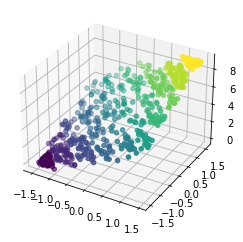

In [11]:
X_train, y_train = get_train_data(3000)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()

train_data = []
for i in range(len(X_train)):
#     train_data.append([X_train[i], X_train_true_labels[i]])
    train_data.append([X_train[i], y_train[i]])
        
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train, c=y_train)

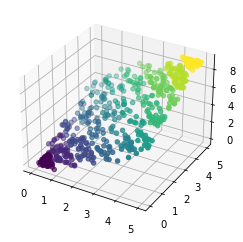

In [12]:
# Plotting the training data, unstandardized
X_train_orig = unstandardize_data(X_train)

ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_train, c=y_train)

In [71]:
boolvec_dim

5

In [72]:
print(rep_bools)

[(1, 0, 1, 0, 0), (0, 0, 1, 0, 0), (0, 1, 1, 0, 0), (0, 0, 0, 0, 0), (0, 0, 1, 1, 0), (0, 1, 1, 0, 1)]


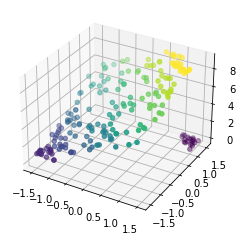

In [8]:
X_test, y_test = get_test_splitB(1000, 1)

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).long()
        
ax = plt.axes(projection='3d')
ax.scatter3D(X_test[:, 0], X_test[:, 1], y_test, c=y_test)

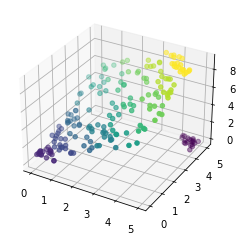

In [10]:
# Plotting the training data, unstandardized
X_train_orig = unstandardize_data(X_test)

ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_test, c=y_test)

In [19]:
len(np.unique(X_test[:, 2:], axis=0))

8

In [14]:
np.unique(X_test[:, 2:], axis=0)

array([[0., 0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 1., 1.],
       [0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 0., 1., 1.],
       [0., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 1., 1.],
       [1., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 1., 1.],
       [1., 0., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0., 1.]], dtype=float32)

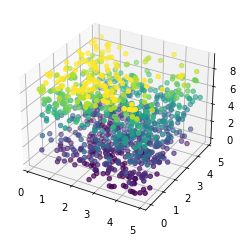

In [15]:
# Plotting the testing data, unstandardized
X_test_orig = unstandardize_data(X_test, cache["X_testB_mean"], cache["X_testB_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_test_orig[:, 0], X_test_orig[:, 1], y_test, c=y_test)

In [13]:
print(cache)

{'X_train_mean': array([2.47794626, 2.52247822]), 'X_train_std': array([1.44276969, 1.44830836]), 'X_testB_mean': array([2.45533037, 2.44018852]), 'X_testB_std': array([1.45195337, 1.43532475])}


## Helper Methods

In [99]:
def get_num_correct(preds, labels):
    pred = preds.max(1, keepdim=True)[1]
    correct = pred.eq(labels.view_as(pred)).sum().item()
    return correct

## Training Model

In [107]:
emb_dims = [2*boolvec_dim, 8*boolvec_dim]
# emb_dims = [0, 0]
batch_size = 256
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [108]:
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[64, 256, 512, 320, 256, 128, 64, 32, 20], \
               output_size=num_classes, hidden_drop_p=0, batch_flag=False)

n_epochs = 100000
loss_values = []
acc_values = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

t = tqdm(range(1, n_epochs+1), miniters=100)
for epoch in t:
    total_loss = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:, :2].float()
        cat_x = inputs[:, 2].long()
        
        optimizer.zero_grad()
        
        preds = model(cont_x, cat_x)
        
        loss = criterion(preds, labels)
        total_loss += loss.item()
        correct += get_num_correct(preds, labels)
        
        loss.backward()
        optimizer.step()
    epoch_loss = total_loss/num_batches
    acc = correct/len(train_data)
    t.set_description(f"-----Epoch: {epoch}/{n_epochs}, Loss: {total_loss/num_batches}, Accuracy: {acc}-----")
    loss_values.append(epoch_loss)
    acc_values.append(acc)

-----Epoch: 13092/100000, Loss: 0.05877398264904817, Accuracy: 0.977-----:  13%|█▎        | 13092/100000 [1:08:43<6:35:35,  3.66it/s]              IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

-----Epoch: 15766/100000, Loss: 0.12641014407078424, Accuracy: 0.954-----:  16%|█▌        | 15765/100000 [1:21:58<6:17:19,  3.72it/s]              IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

-----Epoch: 19362/100000, Loss: 0.1056209784001112, Accu

KeyboardInterrupt: 

Text(0, 0.5, 'Training loss')

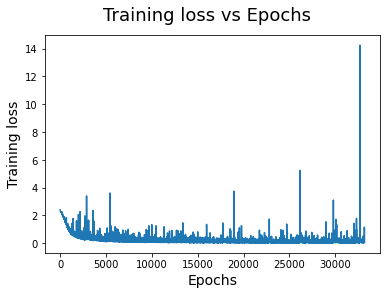

In [110]:
plt.plot(np.array(np.arange(0, 33187)), loss_values)
plt.suptitle('Training loss vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training loss', fontsize=14)

Text(0, 0.5, 'Training accuracy')

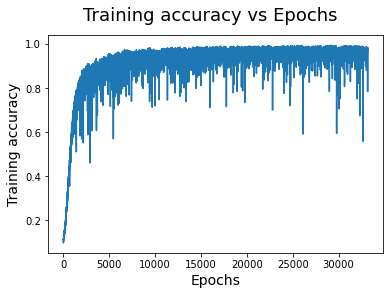

In [112]:
plt.plot(np.array(np.arange(0, 33187)), acc_values)
plt.suptitle('Training accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training accuracy', fontsize=14)

## Model Testing